## Representation Learning for sparse matrix
In this post, I show an example of using Deep Learning techniques with PyTorch to learn compact representation of data like with PCA. The example assume that you are familiar with the theory of the neural networks and Python.

I will use the Denoizing Autoencoders a powerful class of neural networks with remarkable applications (recommandation system, pre-training neural networks, etc.). 
The Denoising Autoencoder is an extension of a classical autoencoder with capability to handle some of the input values to zero (sparse matrix)

Denoizing Autoencoders encodes the input values x, using a function f. It then decodes the encoded values f(x), using a function g, to create output values identical to the input values. It ignore the training error on all 0 input. 

### Overview
- Requirements
- Load Python modules and dataset
- Create model
- Train Model
- Evaluate Model
- Save and load model weights to predict new cases

### 1- Requirements
- Python 3.6
- Pandas
- Numpy
- Matplotlib
- PyTorch
- Scikit Learn

### 2- Load Python modules and create input dataset

In [1]:
# import package
import pandas as pd
import numpy as np
import torch
import pickle

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from torch.autograd import Variable

# set numpy seed for reproducibility
np.random.seed(seed=123)

In [2]:
# Create input dataset
dataset = [[1.0, 1, -1, -1],
          [-1, -1, 1, 1],
          [-1, -1, 1, 1],
          [1, 1, -1, -1],
          [1, 0, -1, -1],
          [1, 1, 0, -1],
          [0, 1, -1, -1],
          [1, 1, -1, 0]]

In [3]:
# create X_train and y_train (x_train = y_train)
x_train = dataset
y_train = dataset

### 3- Create model

In [4]:
# set model parameters
batch_size = len(x_train) # 50
num_epochs = 100
learning_rate = 0.01
size_hidden = 100
n_feature = 4
n_output = 4
batch_no = int(len(x_train) / batch_size)

In [5]:
# create network architecture 
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 25))
        self.decoder = nn.Sequential(
            nn.Linear(25, 100),
            nn.ReLU(),
            nn.Linear(100, 4))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# create network
net = autoencoder()

In [6]:
# define loss
criterion = nn.MSELoss()

In [7]:
# define optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=learning_rate)

In [8]:
# define function to ignore loss on zero input
def denoising(input_tensor, output_tensor):
    """
    Transform each prediction to zero for every zero input.
    It will ignore loss calculation on zero input.
    """
    for i in range(len(input_tensor)):
        for j in range(len(input_tensor[i])):
            if float(input_tensor[i][j]) == 0.0:
                output_tensor[i][j] = 0.0
    return output_tensor

### 4- Train Model

In [9]:
# Start training
epoch_loss = []
running_loss = 0

for epoch in range(num_epochs):
    
    for i in range(batch_no):
        # get training mini-batch
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.tensor(x_train[start:end]).float())
        labels = Variable(torch.tensor(y_train[start:end]).float())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        
        # transform prediction on 0 input to O
        dae_outputs = denoising(inputs, outputs)
        
        # backward
        loss = criterion(dae_outputs, labels)
        loss.backward()
        
        # optimize (update weights)
        optimizer.step()   
    
        # increment loss
        running_loss += loss.item()
        
    if (epoch+1) % 10 == 0:    
        print('Epoch {}'.format(epoch+1), "loss: ", running_loss)
    epoch_loss.append(running_loss)
    running_loss = 0.0

Epoch 10 loss:  0.08637816458940506
Epoch 20 loss:  0.027067460119724274
Epoch 30 loss:  0.002571309683844447
Epoch 40 loss:  0.0027002289425581694
Epoch 50 loss:  0.0019928456749767065
Epoch 60 loss:  0.0012991742696613073
Epoch 70 loss:  0.0013055313611403108
Epoch 80 loss:  0.001304413890466094
Epoch 90 loss:  0.0013053277507424355
Epoch 100 loss:  0.001307744882069528


### 5- Evaluate Model

In [10]:
# get accuracy 
preds = net(torch.tensor(x_train).float())
preds = preds.detach().numpy()

print ("R2 Score: {0}".format(r2_score(preds, np.array(x_train))))
print ("MSE: {0}".format(mean_squared_error(preds, np.array(x_train))))

R2 Score: 0.841334813425972
MSE: 0.11487810989019576


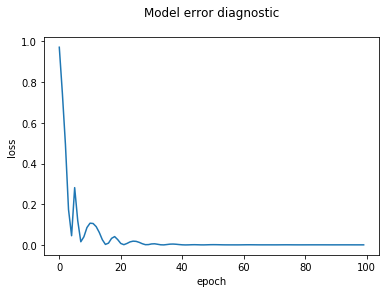

In [11]:
# show loss
plt.plot(epoch_loss)
plt.title('Model error diagnostic\n')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### 6- Save and load model weights to predict new cases

In [12]:
# Save model
pickle.dump(net, open("../model/dae_autoencoder.p", "wb"))

# load model
loaded_net = pickle.load(open("../model/dae_autoencoder.p", "rb"))

# make prediction on trained model
pred = net(torch.tensor([[1.0, 1, -1, -1]]).float())
print ("predict: {0}".format(pred.detach().numpy()))

# make prediction on loaded model
pred = loaded_net(torch.tensor([[1.0, 1, -1, -1]]).float())
print ("predict: {0}".format(pred.detach().numpy()))

predict: [[ 1.035948   1.0361155 -1.0446995 -1.0386586]]
predict: [[ 1.035948   1.0361155 -1.0446995 -1.0386586]]
